### Generate Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
import sklearn.model_selection as train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score


np.random.seed(42)

number_samples = 5000

# categorical features
industry = ['Automotive', 'Finance', 'Healthcare', 'Retail', 'Technology', 'Government', 'Education', 'Manufacturing', 'Food and Beverage', 'Energy']
weighted_industry = np.random.rand(10)
weighted_industry = weighted_industry / weighted_industry.sum()
feature_use = ['low', 'medium', 'high']

def random_dates(start, end, n):
    business_days = pd.date_range(start=start, end=end, freq='B')
    return np.random.choice(business_days, size=n, replace=True)

random_dates(pd.to_datetime('2015-01-01'), pd.to_datetime('2023-01-01'), 5)  # Example usage

array(['2021-06-17T00:00:00.000000000', '2017-12-13T00:00:00.000000000',
       '2020-10-22T00:00:00.000000000', '2019-08-29T00:00:00.000000000',
       '2018-08-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [3]:
customer_data = {
    'customer_id': np.arange(1, number_samples + 1),
    'customer_size': np.random.normal(1500,250, number_samples).astype(int),
    'annual_revenue': np.random.normal(1000000, 200000, number_samples).round(2),
    'industry': np.random.choice(industry, number_samples, p=weighted_industry),
    'c_level_engagement': np.random.choice(feature_use, number_samples, p=[0.6, 0.2, 0.2]),
    'open_deals': np.random.binomial(1, 0.2, number_samples),
    'customer_sign_up_date': random_dates(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-31'), number_samples),
    'amount_ARR_cloud': np.random.lognormal(12, 0.52, number_samples).round(2),
    'amount_ARR_on_prem': np.random.lognormal(9, 0.3, number_samples).round(2),
    'feature_1_usage': np.random.choice(feature_use, number_samples, p=[0.5, 0.3, 0.2]),
    'feature_2_usage': np.random.choice(feature_use, number_samples, p=[0.4, 0.4, 0.2]),
    'feature_3_usage': np.random.choice(feature_use, number_samples, p=[0.3, 0.5, 0.2]),
    'churned': np.random.binomial(1, 0.17, number_samples)
}

In [4]:
df_customers = pd.DataFrame(customer_data)
df_customers['next_renewal_date'] = df_customers['customer_sign_up_date'] + pd.DateOffset(years=3)
df_customers['last_qbr_date'] = df_customers.apply(lambda df: random_dates(df['customer_sign_up_date'], 
                                                            df['next_renewal_date'], 1)[0], 
                                                            axis=1)
df_customers['amount_ARR_total'] = df_customers['amount_ARR_cloud'] + df_customers['amount_ARR_on_prem']
df_customers['customer_age'] = (pd.Timestamp.now() - df_customers['customer_sign_up_date']).dt.days // 30
df_customers.head()

,customer_id,customer_size,annual_revenue,industry,c_level_engagement,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,feature_1_usage,feature_2_usage,feature_3_usage,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age
0,1,1357,1008556.58,Finance,high,0,2021-02-10,204185.47,6982.61,medium,high,low,0,2024-02-10,2021-09-23,211168.08,58
1,2,1268,1098836.04,Energy,low,0,2016-09-30,110100.53,7266.24,low,medium,high,0,2019-09-30,2019-06-14,117366.77,111
2,3,846,1133341.21,Finance,low,0,2011-12-09,135663.57,7431.60,medium,medium,medium,0,2014-12-09,2014-08-22,143095.17,170
3,4,1737,987476.84,Finance,high,1,2017-07-17,222803.19,6652.80,medium,low,medium,0,2020-07-17,2019-12-31,229455.99,101
4,5,1704,905163.79,Food and Beverage,low,0,2010-09-14,217185.20,12329.89,high,low,high,0,2013-09-14,2011-09-30,229515.09,185


In [5]:
df_customers[['customer_sign_up_date','next_renewal_date','last_qbr_date']].head()

,customer_sign_up_date,next_renewal_date,last_qbr_date
0,2021-02-10,2024-02-10,2021-09-23
1,2016-09-30,2019-09-30,2019-06-14
2,2011-12-09,2014-12-09,2014-08-22
3,2017-07-17,2020-07-17,2019-12-31
4,2010-09-14,2013-09-14,2011-09-30


In [6]:
df_customers['days_between_renewal_and_qbr'] = (df_customers['next_renewal_date'] - df_customers['last_qbr_date']).dt.days

# EDA

In [7]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   5000 non-null   int32         
 1   customer_size                 5000 non-null   int32         
 2   annual_revenue                5000 non-null   float64       
 3   industry                      5000 non-null   object        
 4   c_level_engagement            5000 non-null   object        
 5   open_deals                    5000 non-null   int32         
 6   customer_sign_up_date         5000 non-null   datetime64[ns]
 7   amount_ARR_cloud              5000 non-null   float64       
 8   amount_ARR_on_prem            5000 non-null   float64       
 9   feature_1_usage               5000 non-null   object        
 10  feature_2_usage               5000 non-null   object        
 11  feature_3_usage               

In [8]:
df_customers.describe()

,customer_id,customer_size,annual_revenue,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000,5.000000e+03,5000.000000,5000.000000,5000,5000,5.000000e+03,5000.000000,5000.000000
mean,2500.500000,1498.682400,9.959072e+05,0.191000,2016-07-06 19:55:12,1.847705e+05,8484.012946,0.173800,2019-07-07 14:47:19.680000,2018-01-07 12:50:06.720000,1.932545e+05,113.823200,546.081400
min,1.000000,629.000000,2.835875e+05,0.000000,2010-01-01 00:00:00,2.643850e+04,2122.430000,0.000000,2013-01-01 00:00:00,2010-03-04 00:00:00,3.482068e+04,35.000000,0.000000
25%,1250.750000,1330.750000,8.596250e+05,0.000000,2013-04-26 00:00:00,1.130612e+05,6592.890000,0.000000,2016-04-26 00:00:00,2014-10-02 00:00:00,1.215015e+05,74.000000,271.750000
50%,2500.500000,1498.000000,9.957253e+05,0.000000,2016-07-25 00:00:00,1.626816e+05,8074.080000,0.000000,2019-07-25 00:00:00,2018-01-03 00:00:00,1.709775e+05,113.000000,545.000000
75%,3750.250000,1669.000000,1.133897e+06,0.000000,2019-10-07 00:00:00,2.290364e+05,9983.867500,0.000000,2022-10-07 00:00:00,2021-03-31 06:00:00,2.379338e+05,153.000000,818.000000
max,5000.000000,2343.000000,1.708813e+06,1.000000,2022-12-30 00:00:00,1.109749e+06,24793.830000,1.000000,2025-12-30 00:00:00,2025-10-27 00:00:00,1.118157e+06,193.000000,1096.000000
std,1443.520003,246.976456,2.040639e+05,0.393128,NaN,1.020004e+05,2662.783888,0.378975,NaN,NaN,1.020205e+05,45.860124,316.996684


In [9]:
categorical_features = ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']

for col in categorical_features:
    df_customers[col] = pd.Categorical(df_customers[col], 
                                                    categories= feature_use, 
                                                    ordered=True)


In [10]:
for col in categorical_features:
    print(f'{col}: {round(df_customers[col].cat.codes.mean(), 2)}')

c_level_engagement: 0.63
feature_1_usage: 0.69
feature_2_usage: 0.8
feature_3_usage: 0.91


In [11]:
df_customers.isna().sum()

customer_id                     0
customer_size                   0
annual_revenue                  0
industry                        0
c_level_engagement              0
open_deals                      0
customer_sign_up_date           0
amount_ARR_cloud                0
amount_ARR_on_prem              0
feature_1_usage                 0
feature_2_usage                 0
feature_3_usage                 0
churned                         0
next_renewal_date               0
last_qbr_date                   0
amount_ARR_total                0
customer_age                    0
days_between_renewal_and_qbr    0
dtype: int64

In [12]:
df_customers.duplicated().sum()

0

In [13]:
# Numeric columns (int, float, nullable types)
numeric_features = df_customers.select_dtypes(include=['int64', 'float64']).columns.to_list()

# Categorical columns that are explicitly dtype "category"
categorical_features = df_customers.select_dtypes(include=['category']).columns.tolist()

# Nominal (string) features — typical object columns
nominal_categorical_features = df_customers.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Nominal categorical features:", nominal_categorical_features)

Numeric features: ['annual_revenue', 'amount_ARR_cloud', 'amount_ARR_on_prem', 'amount_ARR_total', 'customer_age', 'days_between_renewal_and_qbr']
Categorical features: ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']
Nominal categorical features: ['industry']


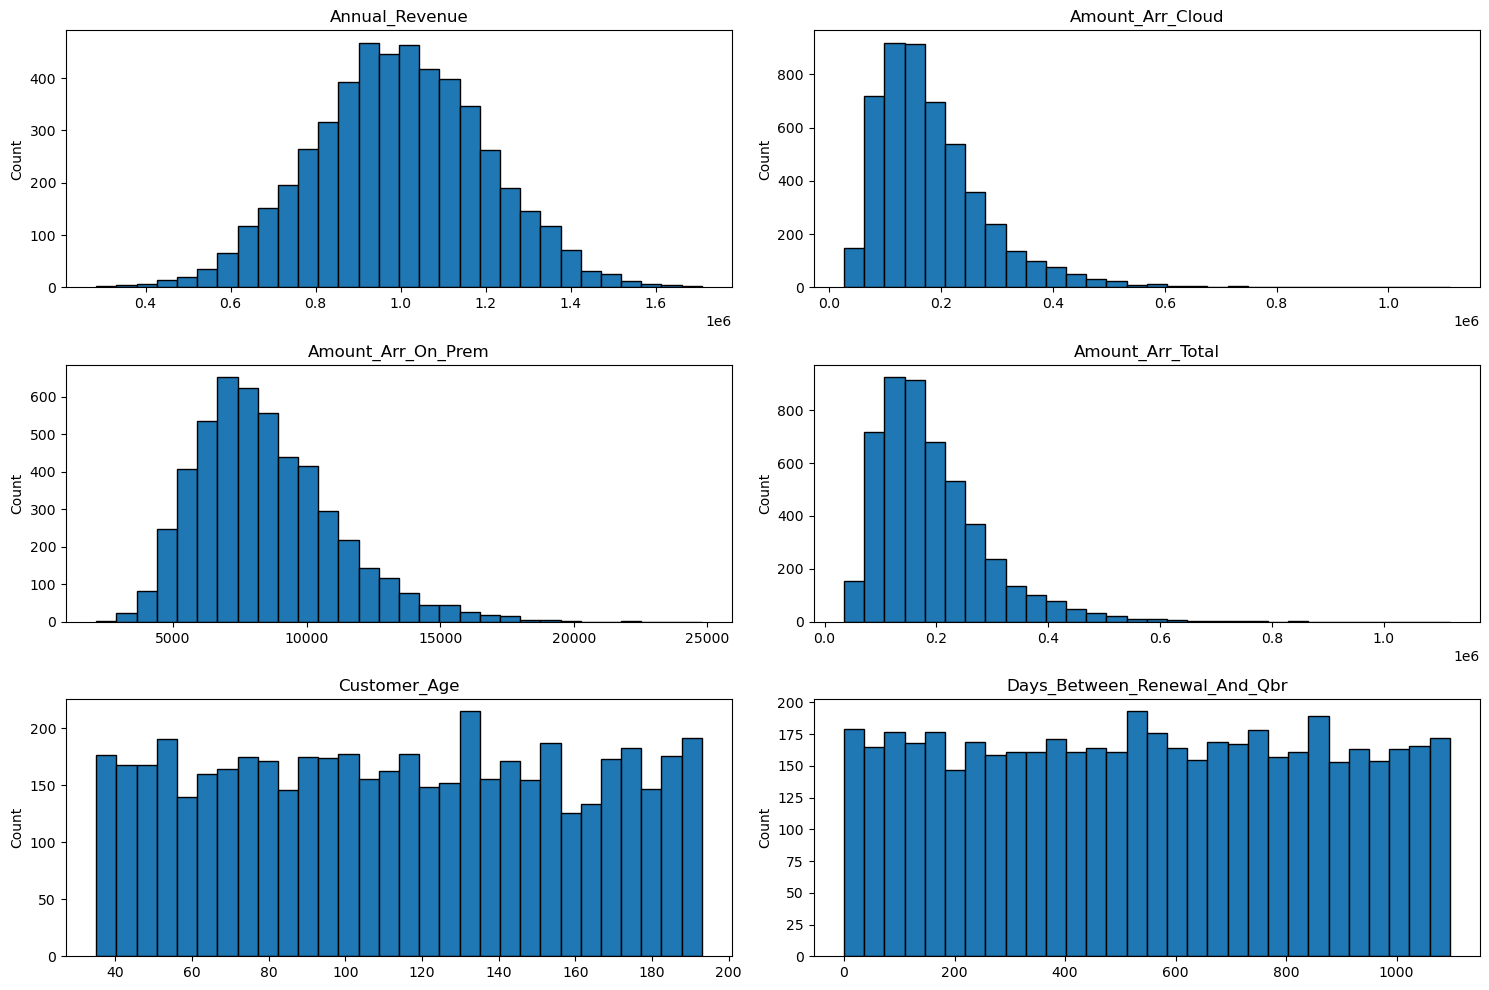

In [14]:
numeric_features = df_customers.select_dtypes(include=['int64', 'float64']).columns

ax = df_customers[numeric_features].hist(
    figsize=(15, 10),
    bins=30,
    edgecolor='black',
    grid=False
)

# Make titles cleaner + adjust layout
for row in ax:
    for subplot in row:
        subplot.set_title(subplot.get_title().title())
        subplot.set_xlabel(subplot.get_xlabel().replace('_', ' ').title())
        subplot.set_ylabel("Count")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix for Numeric Features')

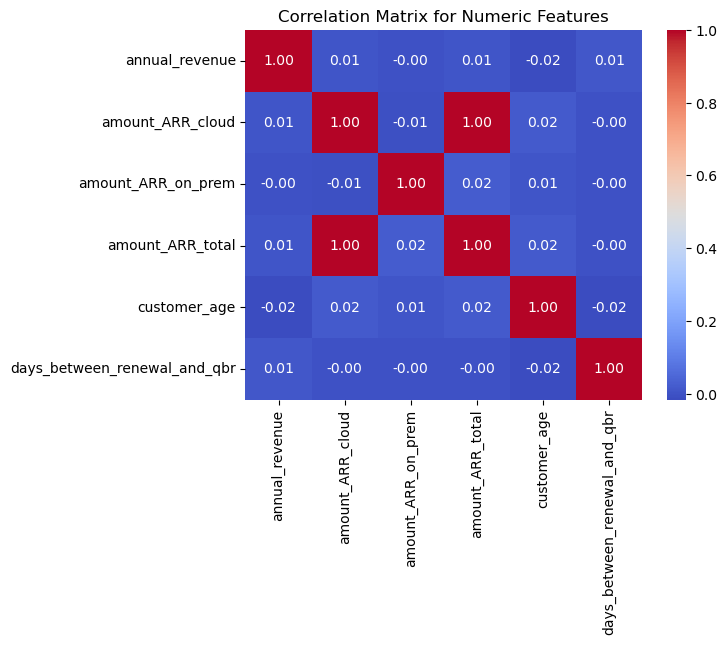

In [15]:
df_customers[numeric_features].corr()
sns.heatmap(df_customers[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')

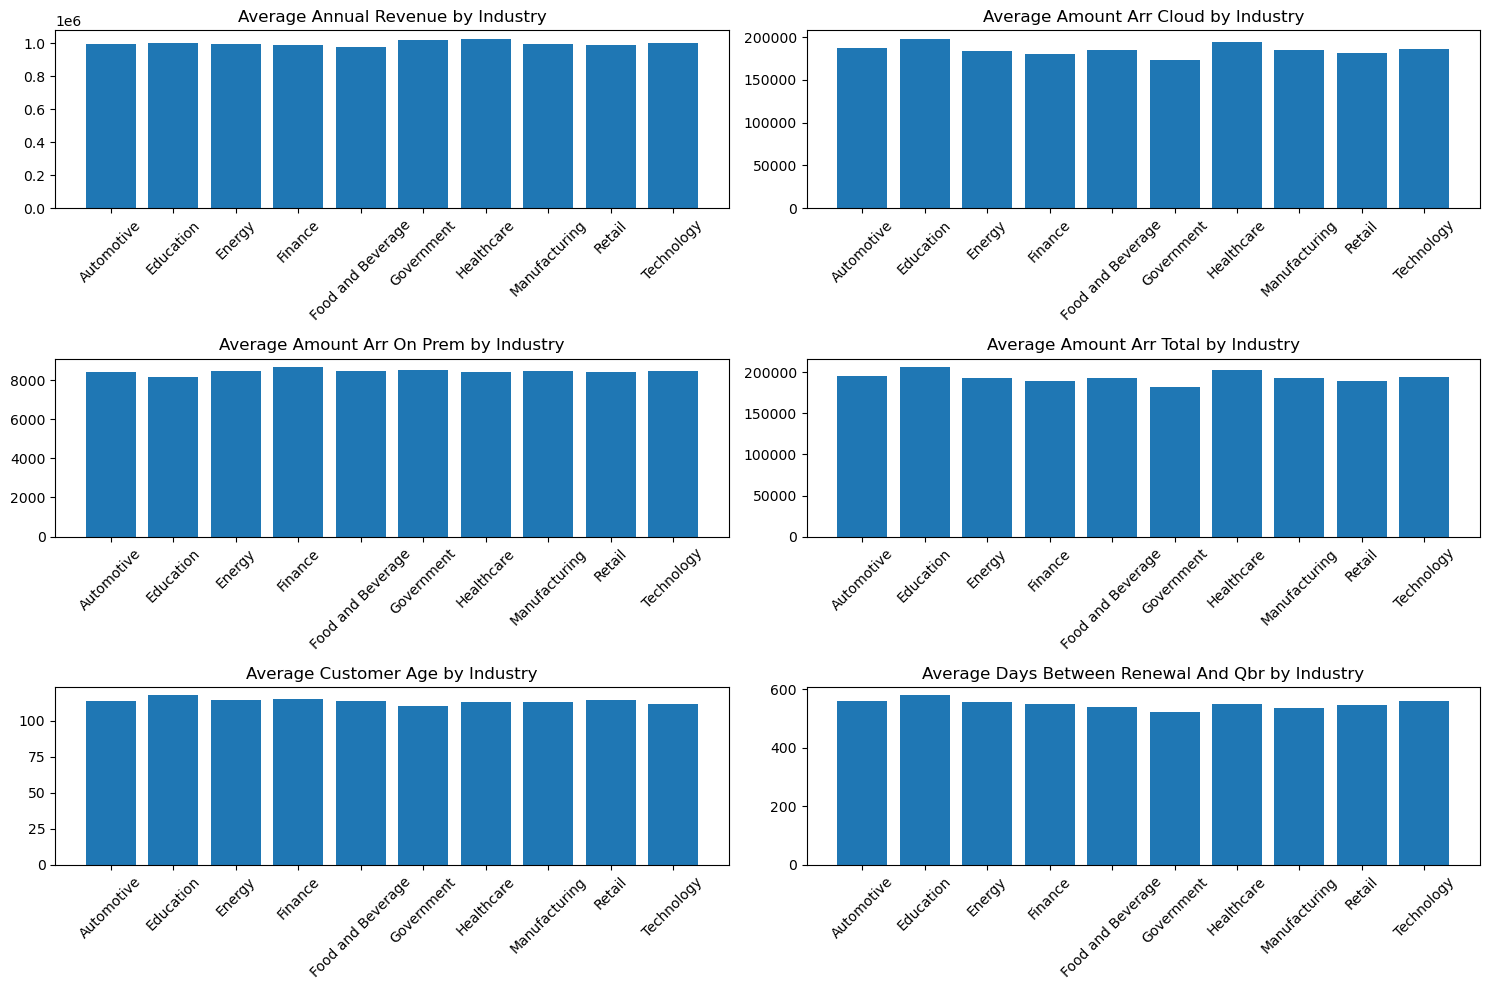

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

all_axes = ax.flatten()

for num_feat, subplot in zip(numeric_features, all_axes):

    industry_group = df_customers.groupby('industry')[num_feat].mean()

    subplot.bar(x=industry_group.index, height=industry_group.values)
    
    subplot.set_title(f'Average {num_feat.replace("_", " ").title()} by Industry')
    subplot.tick_params(axis='x', rotation=45) # Rotate X-labels
    plt.tight_layout()

In [17]:
pd.crosstab(df_customers['industry'], df_customers['churned'], normalize='index')

churned,0,1
industry,,
Automotive,0.833780,0.166220
Education,0.816327,0.183673
Energy,0.843165,0.156835
Finance,0.797539,0.202461
Food and Beverage,0.827645,0.172355
Government,0.856322,0.143678
Healthcare,0.827688,0.172312
Manufacturing,0.814677,0.185323
Retail,0.844948,0.155052


# Preprocessing + Feature Engineering

In [18]:
list(numeric_features).remove('amount_ARR_total')

features = list(numeric_features) + list(categorical_features) + list(nominal_categorical_features)

X = df_customers[features]

y = df_customers['churned']

C:\Users\yusse\AppData\Local\Temp\ipykernel_17744\1277970355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["amount_ARR_cloud","amount_ARR_on_prem"]] = power_transformer.fit_transform(X_amount_ARR)


(array([  2.,   2.,   7.,   9.,  31.,  24.,  67.,  91., 175., 237., 290.,
        355., 368., 440., 491., 499., 422., 403., 338., 256., 165., 123.,
         94.,  52.,  25.,  17.,   9.,   5.,   2.,   1.]),
 array([-3.57725821, -3.33492692, -3.09259563, -2.85026434, -2.60793305,
        -2.36560176, -2.12327047, -1.88093918, -1.63860789, -1.3962766 ,
        -1.15394531, -0.91161402, -0.66928273, -0.42695144, -0.18462015,
         0.05771114,  0.30004243,  0.54237372,  0.78470501,  1.0270363 ,
         1.26936759,  1.51169888,  1.75403017,  1.99636146,  2.23869275,
         2.48102404,  2.72335533,  2.96568662,  3.20801791,  3.4503492 ,
         3.69268049]),
 <BarContainer object of 30 artists>)

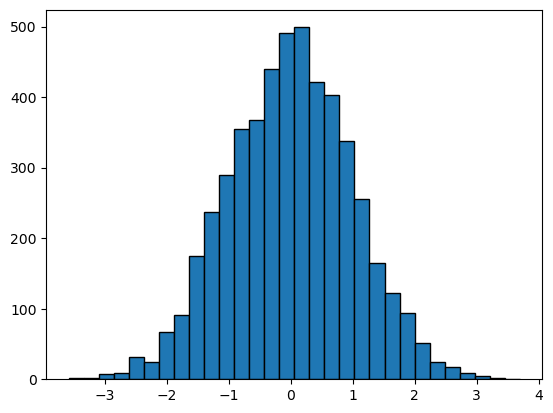

In [19]:
power_transformer = PowerTransformer()
X_amount_ARR = X[["amount_ARR_cloud","amount_ARR_on_prem"]]
X[["amount_ARR_cloud","amount_ARR_on_prem"]] = power_transformer.fit_transform(X_amount_ARR)

plt.hist(X["amount_ARR_cloud"], bins=30, edgecolor='black')

In [20]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categorical_features),
        ('nom', OneHotEncoder(drop='first'), nominal_categorical_features)
    ])

X_preprocessed = pd.DataFrame(column_transformer.fit_transform(X), columns=column_transformer.get_feature_names_out())

In [21]:
var_thres = VarianceThreshold(threshold=0.01)
X_reduced = pd.DataFrame(var_thres.fit_transform(X_preprocessed), columns=X_preprocessed.columns[var_thres.get_support()])

In [22]:
X_train, X_test, y_train, y_test = train_test_split.train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Building the Model

In [30]:
# Hyperparameters

params = {'penalty': ['l1', 'l2'],
          'C': np.arange(0, 100, 0.1)}

In [31]:
log_classifier = LogisticRegression(solver='liblinear')

log_classifier_tuned = RandomizedSearchCV(estimator=log_classifier,
                                          param_distributions=params)

In [32]:
log_classifier_tuned.fit(X_train, y_train)

log_classifier_tuned.best_params_

{'penalty': 'l1', 'C': 47.7}

In [33]:
best_model = log_classifier_tuned.best_estimator_

best_model.score(X_test, y_test)

0.813